In [1]:
from matplotlib import image
import matplotlib.pyplot as plt
import numpy as np
import torch

%load_ext autoreload
%autoreload 2
torch.manual_seed(0)

from IPython.display import clear_output 
clear_output(wait = True)
import sys 
sys.path.append('..\..\..')
from models import LocationScaleFlow, SoftmaxWeight, DIFDensityEstimator,EMDensityEstimator, GeneralizedMultivariateNormalReference
from utils.color_visual import *

(335, 260, 3)


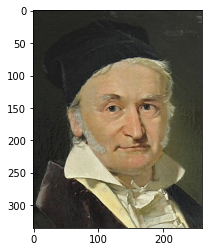

In [2]:
rgb = image.imread("gauss.jpg")
plt.imshow(rgb)
print(rgb.shape)

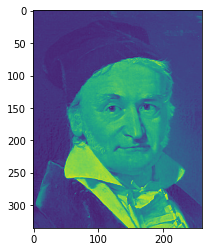

In [3]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
grey = torch.tensor(rgb2gray(rgb))
plt.imshow(grey)

In [13]:
vector_density = grey.flatten()
vector_density = vector_density/torch.sum(vector_density)
lignes, colonnes = grey.shape
num_samples = 2000
cat = torch.distributions.Categorical(probs = vector_density)
categorical_samples = cat.sample([num_samples])
target_samples = torch.cat([(categorical_samples//colonnes).unsqueeze(-1), (categorical_samples%colonnes).unsqueeze(-1)], dim = -1) + torch.rand([num_samples,2])

<ipython-input-13-378efd92233a>:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  target_samples = torch.cat([(categorical_samples//colonnes).unsqueeze(-1), (categorical_samples%colonnes).unsqueeze(-1)], dim = -1) + torch.rand([num_samples,2])


<AxesSubplot:xlabel='x', ylabel='y'>

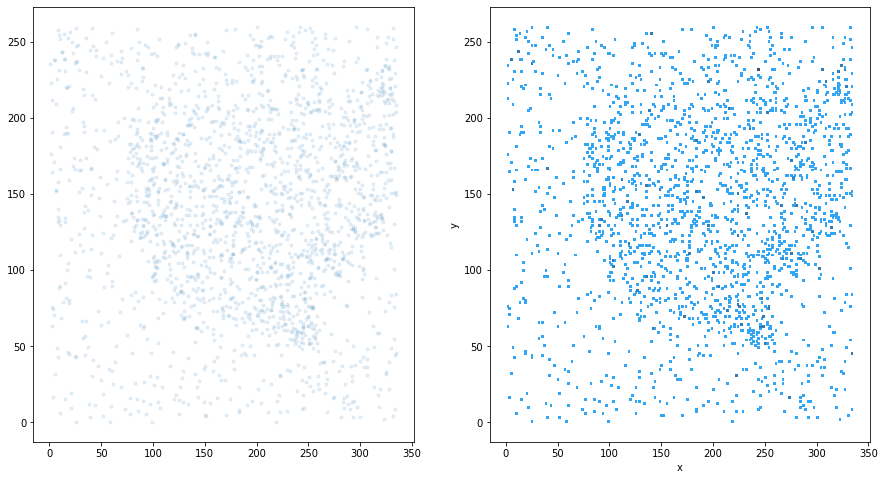

In [14]:
figure = plt.figure(figsize = (15,8))
ax1 = figure.add_subplot(121)
ax1.scatter(target_samples[:,0], target_samples[:, 1], alpha = .1, marker = '.')

import seaborn as sns 
import pandas as pd
ax2 = figure.add_subplot(122)
data_x = pd.DataFrame(target_samples[:,0])
data_x['label'] = 'x'
data_y = pd.DataFrame(target_samples[:,1])
data_y['label'] = 'y'
data = pd.DataFrame()
data['x'] = target_samples[:,0]
data['y'] = target_samples[:,1]
sns.histplot(data, x='x', y='y', bins = (200,200))

100%|██████| 50/50 [00:00<00:00, 84.46it/s, loss = 11.144710540771484]


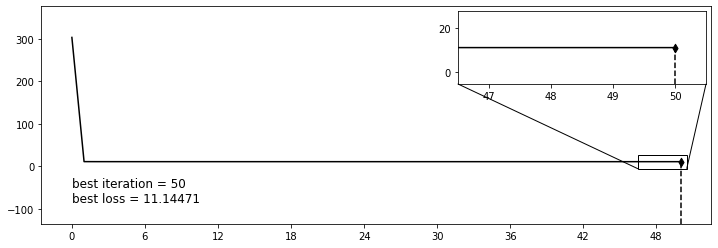

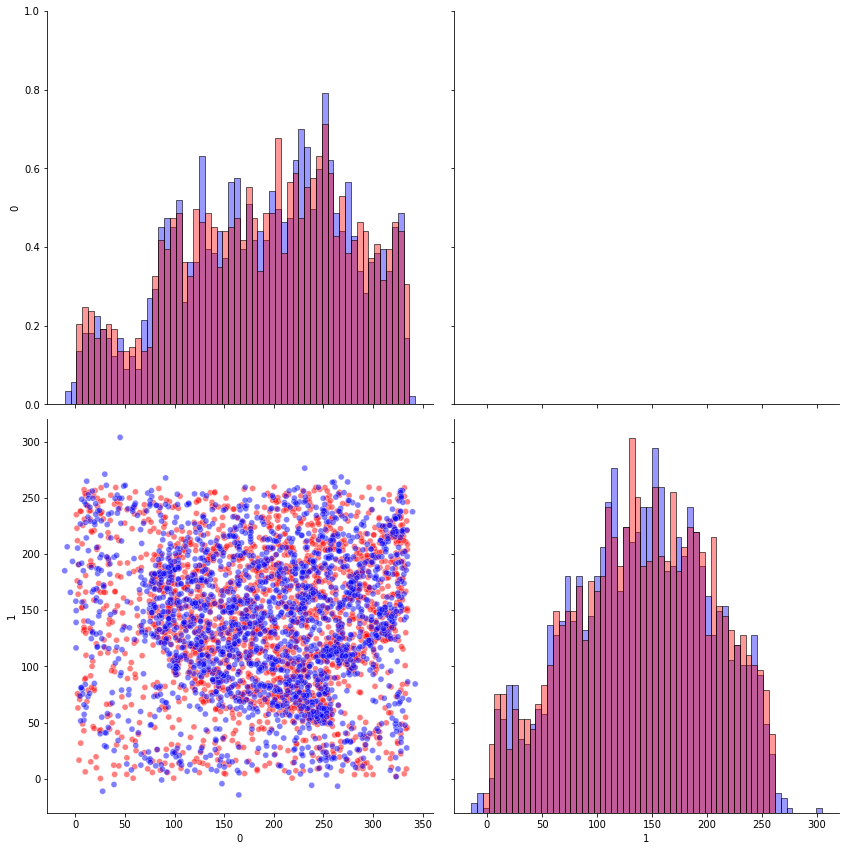

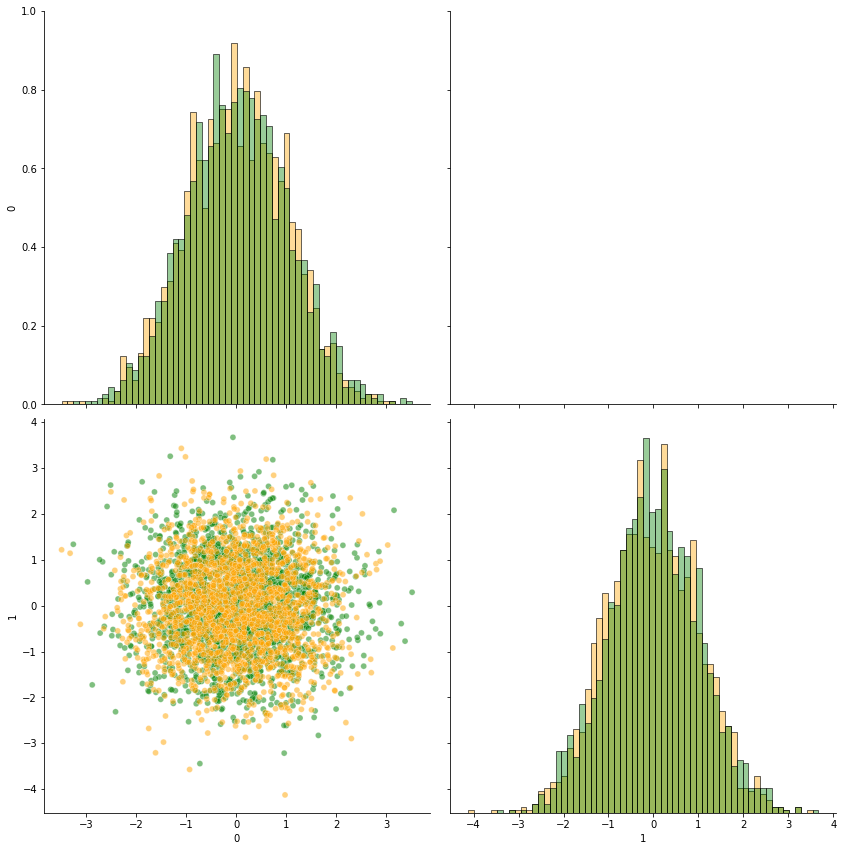

In [32]:
num_samples = target_samples.shape[0]
linspace_x = 7
linspace_y = 7
K = linspace_x*linspace_y
initial_m = torch.cartesian_prod(torch.linspace(0, lignes,linspace_x),torch.linspace(0, colonnes, linspace_y))
EM = EMDensityEstimator(target_samples,K)
EM.mu = initial_m
epochs = 50
loss_values = EM.train(epochs,visual=True)
EM.model_visual()

100%|███████████████| 31/31 [00:14<00:00,  2.08it/s, loss = 11.091591]


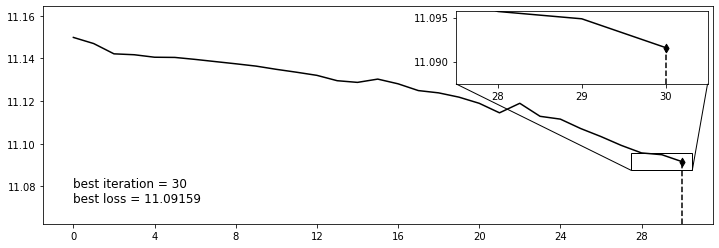

In [33]:
from torch import nn
num_samples = target_samples.shape[0]
epochs = 31
batch_size = 2000


#Start from EM
initial_T = LocationScaleFlow(K,2)
initial_T.m = nn.Parameter(EM.m)
initial_T.log_s = nn.Parameter(EM.log_s)

initial_w = SoftmaxWeight(K, 2, [64,64,64])
initial_w.f[-1].weight = nn.Parameter(torch.zeros(K, 64))
initial_w.f[-1].bias = nn.Parameter(EM.log_pi)

dif = DIFDensityEstimator(target_samples,K)
dif.T = initial_T
dif.w = initial_w

dif.train(epochs,200)
dif.train_visual()

100%|███████████████| 31/31 [00:12<00:00,  2.44it/s, loss = 11.006473]


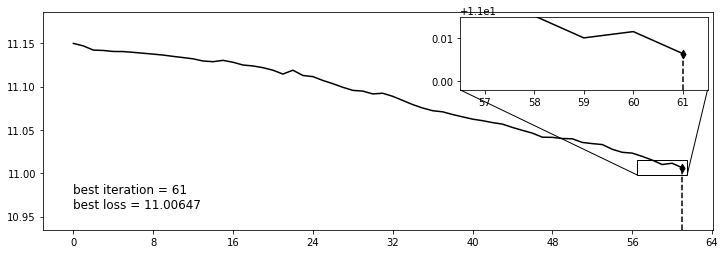

In [34]:
dif.train(epochs,200)
dif.train_visual()

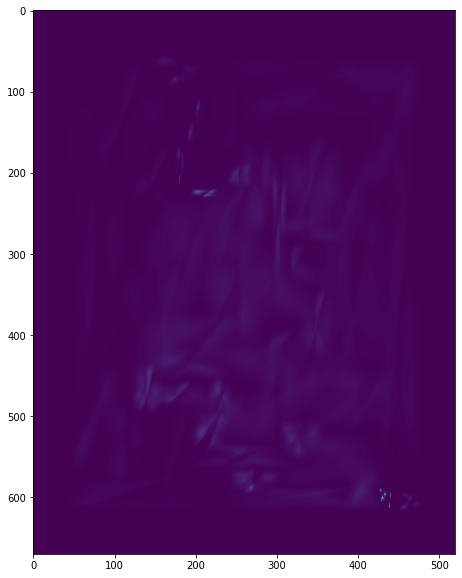

In [36]:
dif_cpu = dif
grid = torch.cartesian_prod(torch.linspace(-lignes/10,1.1*lignes,2*lignes),torch.linspace(-colonnes/10,1.1*colonnes, 2*colonnes))
density = torch.exp(dif_cpu.log_density(grid)).reshape(2*lignes,2*colonnes).T.cpu().detach()
fig = plt.figure(figsize =(10,10))
plt.imshow(torch.flip(torch.flip(density.T,[0,1]),[0,1]))

In [31]:
print(dif.w.f[-1].weight)

Parameter containing:
tensor([[-0.0021,  0.0114,  0.0226,  ...,  0.0256,  0.0258, -0.0229],
        [-0.0024,  0.0065,  0.0421,  ..., -0.0120,  0.0692,  0.0021],
        [-0.0802, -0.0427, -0.0157,  ...,  0.1044,  0.0027, -0.1498],
        ...,
        [-0.0671, -0.0648,  0.0197,  ..., -0.0320, -0.0296,  0.0904],
        [-0.0447, -0.0008, -0.0311,  ...,  0.0577, -0.0298, -0.0485],
        [-0.1099,  0.0161, -0.0255,  ...,  0.0971, -0.0788, -0.0847]],
       requires_grad=True)
